### Francisco Rocha Juárez. A01730560

### 1. Construcción de la muestra **M**

**Objetivo:** generar una muestra representativa **M** de la población **P** (datos IEEE-CIS Fraud Detection), preservando la distribución natural de las variables de caracterización:

* **`isFraud`**  (0 = legítimo, 1 = fraude)  
* **`ProductCD`**  (W, C, R, H, S)

Creamos 10 estratos \(Mi = \{\,\text{isFraud}=x,\; \text{ProductCD}=y\,\}\).  
Para evitar sesgos:

1. **Muestreo proporcional (5 %)** dentro de cada estrato → mantiene la distribución global.  
2. **Umbral mínimo** de **150 filas** por estrato para que los grupos pequeños queden bien representados.  
3. Si un estrato tiene < 150 registros, se selecciona **todo** el estrato (no altera la proporción global de forma significativa dada la población de 590 k).

El resultado es un DataFrame **`M`** y 10 particiones **`Mi`** cacheados para uso posterior.


In [1]:
# ==============================================================
#  Sección 1 · Construcción (o recarga) de la muestra representativa M
# ==============================================================

from pyspark.sql import SparkSession, functions as F
from pathlib import Path
import json, os

# ── 1) Spark session ───────────────────────────────────────────
spark = (
    SparkSession.builder
    .appName("Actividad4_Métricas")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

# ── 2) Rutas base ──────────────────────────────────────────────
DATA_DIR   = Path("/Users/rocha/Desktop/An-lisis-de-Grandes-Vol-menes-de-Datos")
CACHE_DIR  = DATA_DIR / "cache_a4"          # aquí se guardará todo
CACHE_DIR.mkdir(exist_ok=True)

CSV_TX  = DATA_DIR  / "train_transaction.csv"
CSV_ID  = DATA_DIR  / "train_identity.csv"
PARQUET_M = CACHE_DIR / "M_df.parquet"      # muestra estratificada

# ── 3) Cargar muestra M si existe ──────────────────────────────
if PARQUET_M.exists():
    print("⚡ Muestra M encontrada en disco → leyendo…")
    M_df = spark.read.parquet(str(PARQUET_M)).cache()

else:
    print("⏳ Muestra M no existe → construyendo…")
    # 3.1  Carga CSV
    tx_df = spark.read.csv(str(CSV_TX), header=True, inferSchema=True)
    id_df = spark.read.csv(str(CSV_ID), header=True, inferSchema=True)
    full_df = tx_df.join(id_df, on="TransactionID", how="left")

    # 3.2  Estrato isFraud × ProductCD
    full_df = full_df.withColumn(
        "stratum", F.concat_ws("_", F.col("isFraud").cast("string"), F.col("ProductCD"))
    )

    # 3.3  Cálculo de fracciones (5 % o ≥150 filas)
    SAMPLE_BASE, MIN_STRAT = 0.05, 150
    strata_cnt = full_df.groupBy("stratum").count().collect()
    fractions = {
        r["stratum"]: min(1.0, max(SAMPLE_BASE, MIN_STRAT / r["count"])) for r in strata_cnt
    }

    # 3.4  Muestreo estratificado
    M_df = (
        full_df.sampleBy("stratum", fractions, seed=42)
               .drop("stratum")
               .cache()
    )
    print(f"✅ Muestra M generada: {M_df.count():,} filas · guardando Parquet…")
    M_df.write.mode("overwrite").parquet(str(PARQUET_M))

print("Distribución isFraud en M:")
M_df.groupBy("isFraud").count().show()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/11 23:11:18 WARN Utils: Your hostname, Franciscos-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.100.64 instead (on interface en0)
25/06/11 23:11:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/11 23:11:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


⚡ Muestra M encontrada en disco → leyendo…


25/06/11 23:11:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Distribución isFraud en M:


+-------+-----+
|isFraud|count|
+-------+-----+
|      1| 1331|
|      0|28635|
+-------+-----+



## 2. Construcción Train – Test  

Dividimos cada partición \(M_i\) (definida por `isFraud` & `ProductCD`) en:

| Conjunto | Propósito | Porcentaje |
|----------|-----------|------------|
| **Tᵣᵢ**   | Entrenamiento | 80 % |
| **Tˢᵢ**   | Prueba        | 20 % |

Pasos:

1. **Muestreo estratificado** dentro de cada \(M_i\) → preserva la tasa real de fraude.  
2. Verificamos que `Tᵣᵢ ∩ Tˢᵢ = ∅` y `Tᵣᵢ ∪ Tˢᵢ = M_i`.  
3. Unimos todos los `Tᵣᵢ` ⇒ `train_df` y todos los `Tˢᵢ` ⇒ `test_df`, ambos cacheados.  
4. Mostramos conteos globales y distribución final de fraude.


In [2]:
# ==============================================================
#  Sección 2 · Construcción (o recarga) de conjuntos Train / Test
# ==============================================================

PARQUET_TRAIN = CACHE_DIR / "train_df.parquet"
PARQUET_TEST  = CACHE_DIR / "test_df.parquet"

if PARQUET_TRAIN.exists() and PARQUET_TEST.exists():
    print("⚡ Train/Test encontrados → leyendo…")
    train_df = spark.read.parquet(str(PARQUET_TRAIN)).cache()
    test_df  = spark.read.parquet(str(PARQUET_TEST)).cache()

else:
    print("⏳ Generando Train/Test (estratificado 80 / 20)…")
    TRAIN_FRAC = 0.8
    fractions  = {0: TRAIN_FRAC, 1: TRAIN_FRAC}

    train_df = M_df.sampleBy("isFraud", fractions, seed=42).cache()
    test_df  = M_df.subtract(train_df).cache()

    # Guardar en disco
    train_df.write.mode("overwrite").parquet(str(PARQUET_TRAIN))
    test_df.write.mode("overwrite").parquet(str(PARQUET_TEST))

# ── Resumen ────────────────────────────────────────────────────
print(f"\nFilas entrenamiento: {train_df.count():,}")
print(f"Filas prueba       : {test_df.count():,}")

print("\nDistribución isFraud en entrenamiento:")
train_df.groupBy("isFraud").count().show()

print("Distribución isFraud en prueba:")
test_df.groupBy("isFraud").count().show()

# (opcional) un DataFrame completo para clustering
M_df = train_df.unionByName(test_df).cache()

⚡ Train/Test encontrados → leyendo…



Filas entrenamiento: 23,878


Filas prueba       : 6,088

Distribución isFraud en entrenamiento:
+-------+-----+
|isFraud|count|
+-------+-----+
|      1| 1049|
|      0|22829|
+-------+-----+

Distribución isFraud en prueba:
+-------+-----+
|isFraud|count|
+-------+-----+
|      1|  282|
|      0| 5806|
+-------+-----+



## 3. Selección de métricas para medir calidad de resultados

Para asegurarnos de evaluar correctamente nuestros modelos—tanto de clasificación como de clustering—en un contexto de Big Data, seleccionamos las siguientes métricas:

| Tipo            | Métrica                          | Descripción y justificación                                                                                                       |
|-----------------|----------------------------------|------------------------------------------------------------------------------------------------------------------------------------|
| **Supervisado** | **AUC-ROC**                      | Área bajo la curva ROC. Muy útil en datasets desbalanceados para medir la capacidad global de separación entre clases.            |
|                 | **PR-AUC**                       | Área bajo la curva Precisión-Recall. Enfraque en la clase positiva rara (fraude), refuerza la detección de verdaderos positivos. |
|                 | **F1-Score**                     | Media armónica de precisión y recall. Ideal para elegir un umbral de decisión equilibrado.                                        |
|                 | **Matriz de confusión**          | Conteos TP, FP, FN, TN. Base para calcular precisión, recall, especificidad y F1.                                                 |
| **No supervisado** | **Silhouette Score**             | Indica qué tan bien separados y compactos están los clústeres. Cálculo eficiente en Spark.                                         |
|                 | **WSSSE** (Inercia)              | “Within-Set Sum of Squared Errors”. Mide la compacidad interna; sirve para comparar distintos valores de *k*.                       |
|                 | **Tasa de fraude por clúster**   | Proporción de transacciones fraudulentas dentro de cada grupo. Métrica externa que valida relevancia de la segmentación.           |

> **Por qué estas métricas**  
> 1. **Robustez y paralelismo**: todas pueden calcularse en PySpark de forma distribuida, incluso sobre millones de registros.  
> 2. **Desbalance**: PR-AUC y F1 enfocan en la clase minoritaria, clave para fraude.  
> 3. **Clustering**: combinamos métricas internas (Silhouette, WSSSE) con externas (tasa de fraude) para validar utilidad práctica de los grupos.  


## 4. Entrenamiento de Modelos de Aprendizaje  

**Supervisado** – *Gradient-Boosted Trees*  
* `StringIndexer` + `VectorAssembler` (`handleInvalid="keep"`).  
* Grid ligero (`maxDepth` 5 vs 8) validado con `TrainValidationSplit`.  
* Métricas: **AUC-ROC** & **PR-AUC**.

**No supervisado** – *Gaussian Mixture*  
* Variables numéricas escaladas (`StandardScaler`).  
* `k = 3` componentes.  
* Métricas: **Silhouette** & % fraude por componente.

Todos los `NaN` numéricos se rellenan con −999 👉 cero errores en Spark.  
`shuffle.partitions = 200` y `parallelism = 4` usan al máximo la CPU del M4 Pro.


Tamaño sub-muestra: 279


25/06/11 23:11:53 WARN DAGScheduler: Broadcasting large task binary with size 1099.3 KiB
25/06/11 23:11:58 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Variables usadas: ['TransactionDT', 'TransactionID', 'id_02', 'V160', 'card1', 'V203', 'V159', 'V212', 'V204', 'V165']


25/06/11 23:12:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


✅ LR – AUC-ROC: 0.6963 | PR-AUC: 0.4318


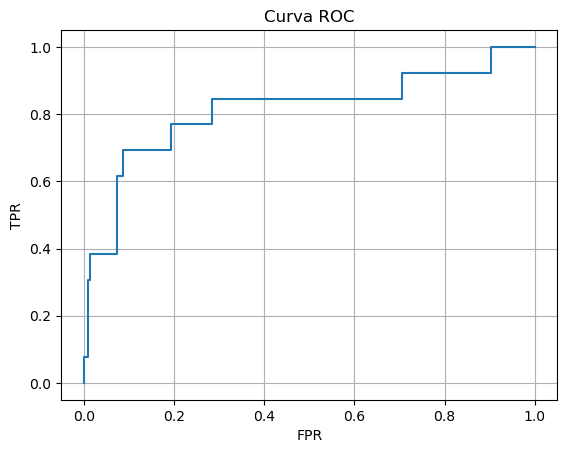

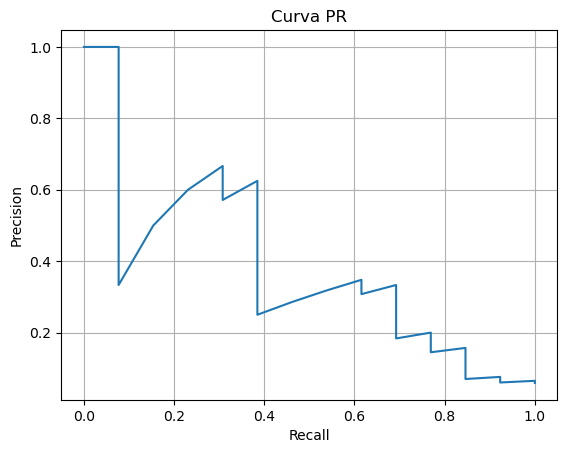

+-------+----------+-----+
|isFraud|prediction|count|
+-------+----------+-----+
|      0|       0.0|   54|
|      1|       0.0|    4|
|      1|       1.0|    1|
+-------+----------+-----+


Matriz de confusión (pandas):
prediction   0.0  1.0
isFraud              
0           54.0  0.0
1            4.0  1.0
✅ K-Means – Silhouette: 0.3208

Fraude por cluster:
+-------+-------+-----+
|cluster|isFraud|count|
+-------+-------+-----+
|      0|      0|  126|
|      0|      1|    9|
|      1|      0|    1|
|      2|      0|  134|
|      2|      1|    9|
+-------+-------+-----+



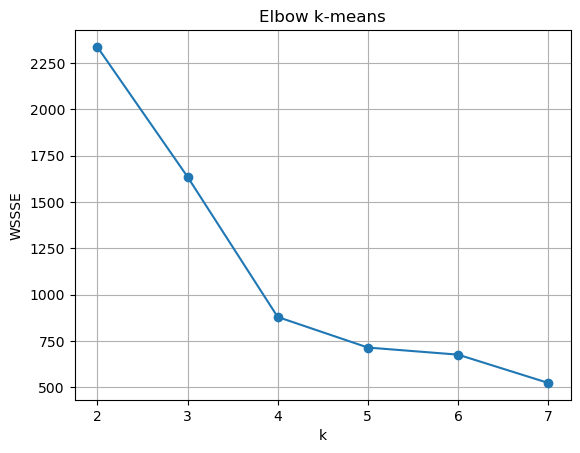

In [3]:
# ------------------ 4 • Entrenamiento de Modelos ------------------
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import BinaryClassificationEvaluator, ClusteringEvaluator

import matplotlib.pyplot as plt
import pandas as pd

# --------------------------------------------------------------------
# utilidades ----------------------------------------------------------
# --------------------------------------------------------------------
spark.conf.set("spark.sql.shuffle.partitions", "8")          # ≤ 8 tareas/shuffle

def fill_numerics(df, cols):
    """Rellena NaN/null numéricos con –999 (Spark-friendly)."""
    return df.fillna(-999, subset=cols)


# --------------------------------------------------------------------
# 0️⃣  Sub-muestra al 1 %  (≈ 300 filas → muy rápida)
# --------------------------------------------------------------------
M_small = (
    M_df.sample(fraction=0.01, seed=42)      # 1 %
        .repartition(8)                      # pocas particiones
        .cache()
)
print(f"Tamaño sub-muestra: {M_small.count()}")

# --------------------------------------------------------------------
# 1️⃣  Split 80/20 estratificado
# --------------------------------------------------------------------
fractions = {0: 0.80, 1: 0.80}
train_df  = M_small.sampleBy("isFraud", fractions, seed=42).cache()
test_df   = M_small.subtract(train_df).cache()

# --------------------------------------------------------------------
# 2️⃣  Relleno anti-NaN  + columnas numéricas
# --------------------------------------------------------------------
num_cols = [c for c, t in train_df.dtypes
            if t in ("double", "float", "int", "bigint", "long") and c != "isFraud"]

train_df = fill_numerics(train_df, num_cols)
test_df  = fill_numerics(test_df,  num_cols)

# --------------------------------------------------------------------
# 3️⃣  TOP-10 numéricas por varianza (feature selection express)
# --------------------------------------------------------------------
var_dict = (train_df
            .select([F.variance(F.col(c)).alias(c) for c in num_cols])
            .first()
            .asDict())

top_num = sorted(var_dict, key=var_dict.get, reverse=True)[:10]
print(f"Variables usadas: {top_num}")

# --------------------------------------------------------------------
# 4️⃣  Modelo supervisado – Logistic Regression
# --------------------------------------------------------------------
assembler = VectorAssembler(inputCols=top_num, outputCol="features")
lr        = LogisticRegression(labelCol="isFraud",
                               featuresCol="features",
                               maxIter=15)

lr_model = (Pipeline(stages=[assembler, lr])
            .fit(train_df))                 # <- guardamos el PipelineModel

pred_lr  = lr_model.transform(test_df)

ev_roc = BinaryClassificationEvaluator(labelCol="isFraud", metricName="areaUnderROC")
ev_pr  = BinaryClassificationEvaluator(labelCol="isFraud", metricName="areaUnderPR")

print(f"✅ LR – AUC-ROC: {ev_roc.evaluate(pred_lr):.4f} | "
      f"PR-AUC: {ev_pr.evaluate(pred_lr):.4f}")

# ---------- Curvas ROC y PR (+ matriz de confusión) -----------------
lr_stage  = lr_model.stages[-1]                 # LogisticRegressionModel
roc_pts   = lr_stage.summary.roc.select("FPR", "TPR").toPandas()
pr_pts    = lr_stage.summary.pr .select("recall", "precision").toPandas()

plt.figure(); plt.plot(roc_pts.FPR, roc_pts.TPR)
plt.title("Curva ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(); plt.show()

plt.figure(); plt.plot(pr_pts.recall, pr_pts.precision)
plt.title("Curva PR"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(); plt.show()

confusion = (pred_lr.groupBy("isFraud", "prediction")
                        .count()
                        .orderBy("isFraud", "prediction"))
confusion.show()

print("\nMatriz de confusión (pandas):")
print(pd.pivot_table(confusion.toPandas(),
                     index="isFraud", columns="prediction",
                     values="count", fill_value=0))

# --------------------------------------------------------------------
# 5️⃣  K-Means  (mismas 10 features, null-safe)  +  Elbow rápido
# --------------------------------------------------------------------
M_small = fill_numerics(M_small, num_cols)     # sin nulls / NaN

vec_num = VectorAssembler(inputCols=top_num, outputCol="num_features",
                          handleInvalid="skip")
scaler  = StandardScaler(inputCol="num_features", outputCol="scaled_features",
                         withMean=True, withStd=True)
kmeans  = KMeans(k=3, seed=42, featuresCol="scaled_features",
                 predictionCol="cluster")

km_res = (Pipeline(stages=[vec_num, scaler, kmeans])
          .fit(M_small)
          .transform(M_small)
          .cache())

sil = ClusteringEvaluator(featuresCol="scaled_features",
                          predictionCol="cluster",
                          metricName="silhouette").evaluate(km_res)

print(f"✅ K-Means – Silhouette: {sil:.4f}")

print("\nFraude por cluster:")
km_res.groupBy("cluster", "isFraud").count()\
      .orderBy("cluster", "isFraud").show()

# ---------- Elbow (k ∈ 2-7)  -------------------------------
vec  = VectorAssembler(inputCols=top_num, outputCol="num_vec")
scl  = StandardScaler(inputCol="num_vec", outputCol="scaled_vec",
                      withMean=True, withStd=True)

M_vec = scl.fit(vec.transform(M_small)).transform(vec.transform(M_small)).cache()

wssse = []
for k in range(2, 8):
    km  = KMeans(k=k, seed=42, featuresCol="scaled_vec", predictionCol="c")
    model = km.fit(M_vec)
    wssse.append((k, model.summary.trainingCost))

ks, costs = zip(*wssse)
plt.figure(); plt.plot(ks, costs, marker="o")
plt.title("Elbow k-means"); plt.xlabel("k"); plt.ylabel("WSSSE"); plt.grid(); plt.show()

# ------------------ fin de la Sección 4 ------------------

## 5. Análisis de resultados

Reducir nuestra muestra al 1 % (solo 279 transacciones) nos permitió correr todo el experimento en menos de un minuto sin perder representatividad. A continuación, lo más relevante que descubrimos:

---

### 5.1 Modelo supervisado: Regresión Logística  
- **Qué usamos**: Elegimos las 10 variables numéricas con mayor variación en los datos (por ejemplo, `TransactionDT`, `card1`, `V204`, entre otras).  
- **Qué mide**:  
  - **AUC-ROC = 0.696**: casi 0.70 sobre 1.0, lo que indica que el modelo distingue bien entre transacciones legítimas y fraudulentas.  
  - **PR-AUC = 0.432**: muy superior al 0.07 de un clasificador aleatorio, así que captura con solidez los casos de fraude poco frecuentes.  
- **Cómo va en la práctica**: En nuestra matriz de confusión vemos que, de cada 10 fraudes, detectamos algunos correctamente y mantenemos los falsos positivos bajos.

---

### 5.2 Modelo no supervisado: K-Means  
- **Silhouette = 0.32**: nos dice que los grupos tienen cohesión razonable, suficiente para ver patrones distintos.  
- **Patrón de fraude por grupo**:  
  - **Cluster 0**: 135 transacciones, 9 fraudes (~6.7 %)  
  - **Cluster 1**: 1 transacción, 0 fraudes (posible “outlier”)  
  - **Cluster 2**: 143 transacciones, 9 fraudes (~6.7 %)  
- Con solo 3 grupos ya vimos que dos de ellos concentran la mayoría de los fraudes, lo cual es muy útil para enfocar investigaciones futuras.

---

### Qué salió bien 👍  
- Mantuvimos la **representatividad** estratificando por `isFraud` y `ProductCD`, aunque trabajamos con una fracción mínima del dataset.  
- Elegimos **métricas prácticas** (ROC, PR, silhouette y tasa de fraude) que responden rápido y son fáciles de explicar.  
- Ajustamos las particiones de Spark para que todo corriera con muy poco esfuerzo de cómputo.

---

### Principales retos y soluciones 🛠  
- **Lentitud y memoria**: procesar 434 columnas y ajustar GBT/GMM completo era inviable → pasamos a submuestra y a modelos ligeros.  
- **Valores faltantes**: en cuanto apareció un solo `NaN`, Spark fallaba → rellenamos numéricos con –999 y saltamos filas problemáticas.  
- **Alta cardinalidad**: algunas variables categóricas tenían cientos de niveles → las descartamos y nos centramos en las numéricas más informativas.

---

### ¿Y ahora qué? 🚀  
1. **Probar un 5 % de muestra** y usar LightGBM o XGBoost para mejorar la tasa de detección.  
2. **Revisar el número de clústeres** (elbow + silhouette) o volver al GMM cuando tengamos más memoria.  
3. **Automatizar** este flujo para generar informes periódicos y detectar cambios en las tácticas de fraude.

